In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from os.path import join
device = "cuda" if torch.cuda.is_available() else "cpu"

Try to study the RADIO base model (distilled from the giant model)

In [ ]:
from PIL import Image
from io import BytesIO
import requests
import torch
from torch.nn import functional as F
from torchvision.transforms.functional import pil_to_tensor
# model_version="radio_v2.5-g" # for RADIOv2.5-g model (ViT-H/14)
# model_version="radio_v2.5-h" # for RADIOv2.5-H model (ViT-H/16)
# model_version="radio_v2.5-l" # for RADIOv2.5-L model (ViT-L/16)
model_version="radio_v2.5-b" # for RADIOv2.5-B model (ViT-B/16)
#model_version="e-radio_v2" # for E-RADIO
model = torch.hub.load('NVlabs/RADIO', 'radio_model', version=model_version, progress=True, skip_validation=True)
model.cuda().eval()

response = requests.get('https://github.com/NVlabs/RADIO/raw/main/assets/radio.png')
x = Image.open(BytesIO(response.content)).convert('RGB')
x = pil_to_tensor(x).to(dtype=torch.float32, device='cuda')
x.div_(255.0)  # RADIO expects the input values to be between 0 and 1
x = x.unsqueeze(0) # Add a batch dimension
nearest_res = model.get_nearest_supported_resolution(*x.shape[-2:])
x = F.interpolate(x, nearest_res, mode='bilinear', align_corners=False)
if "e-radio" in model_version:
    model.model.set_optimal_window_size(x.shape[2:]) #where it expects a tuple of (height, width) of the input image.
# RADIO expects the input to have values between [0, 1]. It will automatically normalize them to have mean 0 std 1.
summary, spatial_features = model(x)
# By default, RADIO will return the spatial_features in NLC format, with L being a combined height/width dimension.
# You can alternatively ask for the features in the more computer-vision-convenient format NCHW the following way:
summary, spatial_features = model(x, feature_fmt='NCHW')
assert spatial_features.ndim == 4

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main


In [21]:
model.get_nearest_supported_resolution(*x.shape[2:])

Resolution(height=304, width=304)

In [9]:
summary.shape

torch.Size([1, 2304])

In [10]:
spatial_features.shape

torch.Size([1, 768, 19, 19])

### Fetch features and understand feature structure

In [4]:
model.feature_normalizer

Identity()

In [5]:
print(model.model.patch_generator.num_cls_tokens) # number of cls tokens
print(model.num_cls_tokens)
print(model.summary_idxs) # indices of the summary tokens that provide the summary 
print(model.model.patch_generator.num_skip) # number of skip tokens, after which there are only spatial tokens
print(model.num_summary_tokens) # number of summary tokens

4
4
tensor([0, 1, 2], device='cuda:0')
8
8


### Fit encoding models for vision transformer

In [6]:
import sys
sys.path.append(r"/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import os
from os.path import join
import torch as th
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from circuit_toolkit.plot_utils import show_imgrid
from circuit_toolkit.layer_hook_utils import featureFetcher
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
from circuit_toolkit.plot_utils import saveallforms
from core.data_utils import load_neural_data, load_from_hdf5, parse_image_fullpaths
from core.model_load_utils import load_model_transform
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit

In [15]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"

In [16]:
stimuli_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli"
ephys_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"

data_path = join(ephys_root, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
# datapath_day3 = join(ephys_root, "vvs_accentuate_day3_normalize_red_20250123-20250126.hdf5")

imgdir_shared = join(stimuli_root, "shared1000")
imgdir = join(stimuli_root, "stimuli_pilot_20241119/results")
# imgdir_day3 = join(stimuli_root, "results_12-01-2025")
data = load_from_hdf5(data_path)
print("subjects:", list(data.keys()))

subjects: ['red_20241212-20241220']


In [17]:
subject_id = 'red_20241212-20241220'
data_dict = load_neural_data(data_path, subject_id, None)
data_dict['image_fps'] = parse_image_fullpaths(data_dict["stimulus_names"], [imgdir_shared, imgdir])
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
figdir = join(dataroot, subject_id, "model_outputs")
os.makedirs(figdir, exist_ok=True)

All stimulus files were found


In [24]:
from torchvision import transforms as T
from circuit_toolkit.layer_hook_utils import featureFetcher, recursive_print

In [26]:
recursive_print(model, deepest=3)

[RADIOModel]
(model): VisionTransformer
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential
    (0): Block
    (1): Block
    (2): Block
    (3): Block
    (4): Block
    (5): Block
    (6): Block
    (7): Block
    (8): Block
    (9): Block
    (10): Block
    (11): Block
  (norm): Identity()
  (fc_norm): Identity()
  (head_drop): Dropout(p=0.0, inplace=False)
  (head): Identity()
  (patch_generator): ViTPatchGenerator
    (im_to_patches): Im2Patches()
    (embedder): ViTPatchLinear(in_features=768, out_features=768, bias=False)
    (cls_token): ClsToken()
    (patch_normalizer): Identity()
(input_conditioner): InputConditioner()
(adaptors): ModuleDict()
(feature_normalizer): Identity()


In [29]:
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
module_names = [name for name in fetcher.module_names.values() if ".model.blocks.Block" in name] #  if ".blocks.NestedTensorBlock" in name

In [30]:
module_names

['.model.blocks.Block0',
 '.model.blocks.Block1',
 '.model.blocks.Block2',
 '.model.blocks.Block3',
 '.model.blocks.Block4',
 '.model.blocks.Block5',
 '.model.blocks.Block6',
 '.model.blocks.Block7',
 '.model.blocks.Block8',
 '.model.blocks.Block9',
 '.model.blocks.Block10',
 '.model.blocks.Block11']

In [113]:
modelname = "radio_v2.5-b"

In [114]:
batch_size = 96
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
modelname = "radio_v2.5-b"  # for RADIOv2.5-B model (ViT-B/16)
model_version = modelname
resolution = (224, 224)
#model_version="e-radio_v2" # for E-RADIO
radio_model = torch.hub.load('NVlabs/RADIO', 'radio_model', version=model_version, progress=True, skip_validation=True)
radio_model = radio_model.eval().to(device)
radio_model.requires_grad_(False)
transforms_pipeline = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Prepare dataset with transforms
dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
# Prepare fetcher
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
module_names = [name for name in fetcher.module_names.values() if ".model.blocks.Block" in name]
# Add hooks to all layers / blocks in resnet50
for name in module_names: 
    fetcher.record(name, store_device='cpu', ingraph=False, )

# # Record features
feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()
th.cuda.empty_cache()

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main


The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/11 [00:00<?, ?it/s]

.model.blocks.Block0 torch.Size([1028, 204, 768])
.model.blocks.Block1 torch.Size([1028, 204, 768])
.model.blocks.Block2 torch.Size([1028, 204, 768])
.model.blocks.Block3 torch.Size([1028, 204, 768])
.model.blocks.Block4 torch.Size([1028, 204, 768])
.model.blocks.Block5 torch.Size([1028, 204, 768])
.model.blocks.Block6 torch.Size([1028, 204, 768])
.model.blocks.Block7 torch.Size([1028, 204, 768])
.model.blocks.Block8 torch.Size([1028, 204, 768])
.model.blocks.Block9 torch.Size([1028, 204, 768])
.model.blocks.Block10 torch.Size([1028, 204, 768])
.model.blocks.Block11 torch.Size([1028, 204, 768])
FeatureFetcher hooks all freed


### Neural Regression and prediction

In [7]:
import time
from neural_regress.regress_lib import transform_features2Xdict, sweep_regressors, MultiTaskLassoCV, MultiOutputSeparateLassoCV, RidgeCV

In [8]:
summary_idxs = model.summary_idxs.cpu()
max_summary_idx = summary_idxs.max() + 1
num_skip = model.model.patch_generator.num_skip
num_cls_tokens = model.model.patch_generator.num_cls_tokens
def get_summary_flatten(X):
    return X[:, summary_idxs, :].flatten(1)

def get_extra_cls_flatten(X):
    return X[:, max_summary_idx:num_cls_tokens, :].flatten(1)

def get_cls_without_summary_flatten(X):
    return X[:, max_summary_idx:num_skip, :].flatten(1)

def get_maxpool_space_token(X):
    return X[:, num_skip:, :].max(dim=1)[0]

def get_avgpool_space_token(X):
    return X[:, num_skip:, :].mean(dim=1)


In [9]:
Xtransforms_dict = {
    "summary_token_flatten": get_summary_flatten,
    "extra_cls_token_flatten": get_extra_cls_flatten,
    "maxpool_space_token": get_maxpool_space_token,
    "avgpool_space_token": get_avgpool_space_token,
    "cls_without_summary_token_flatten": get_cls_without_summary_flatten,
}

In [10]:
import torch
import torch.nn as nn

class SummaryFlatten(nn.Module):
    def __init__(self, summary_idxs: torch.LongTensor):
        super().__init__()
        # register_idxs as a buffer so it moves with .to(device), .eval(), etc.
        self.register_buffer('summary_idxs', summary_idxs)

    def forward(self, X: torch.Tensor):
        # X: (B, T, C)
        return X[:, self.summary_idxs, :].flatten(1)


class ExtraClsFlatten(nn.Module):
    def __init__(self, max_summary_idx: int, num_cls_tokens: int):
        super().__init__()
        self.max_summary_idx = max_summary_idx
        self.num_cls_tokens = num_cls_tokens

    def forward(self, X: torch.Tensor):
        return X[:, self.max_summary_idx : self.num_cls_tokens, :].flatten(1)


class ClsWithoutSummaryFlatten(nn.Module):
    def __init__(self, max_summary_idx: int, num_skip: int):
        super().__init__()
        self.max_summary_idx = max_summary_idx
        self.num_skip = num_skip

    def forward(self, X: torch.Tensor):
        return X[:, self.max_summary_idx : self.num_skip, :].flatten(1)


class MaxPoolSpaceToken(nn.Module):
    def __init__(self, num_skip: int):
        super().__init__()
        self.num_skip = num_skip

    def forward(self, X: torch.Tensor):
        # returns (B, C)
        return X[:, self.num_skip:, :].max(dim=1)[0]


class AvgPoolSpaceToken(nn.Module):
    def __init__(self, num_skip: int):
        super().__init__()
        self.num_skip = num_skip

    def forward(self, X: torch.Tensor):
        # returns (B, C)
        return X[:, self.num_skip:, :].mean(dim=1)

In [11]:
summary_idxs = model.summary_idxs.cpu()
max_summary_idx = summary_idxs.max() + 1
num_skip = model.model.patch_generator.num_skip
num_cls_tokens = model.model.patch_generator.num_cls_tokens

Xtransforms_dict = {
    "summary_token_flatten": SummaryFlatten(summary_idxs),
    "extra_cls_token_flatten": ExtraClsFlatten(max_summary_idx, num_cls_tokens),
    "maxpool_space_token": MaxPoolSpaceToken(num_skip),
    "avgpool_space_token": AvgPoolSpaceToken(num_skip),
    "cls_without_summary_token_flatten": ClsWithoutSummaryFlatten(max_summary_idx, num_skip),
}

In [120]:
Xdict_lyrswp = {}
Xtfmer_lyrswp = {}
for layer in module_names:
    for dimred_str, transform_func in Xtransforms_dict.items():
        t0 = time.time()
        Xdict_lyrswp[f"{layer}_{dimred_str}"] = transform_func(feat_dict_lyrswp[layer])
        Xtfmer_lyrswp[f"{layer}_{dimred_str}"] = transform_func
        print(f"Time taken to transform {layer} x {dimred_str}: {time.time() - t0:.3f}s")

Time taken to transform .model.blocks.Block0 x summary_token_flatten: 0.002s
Time taken to transform .model.blocks.Block0 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block0 x maxpool_space_token: 0.274s
Time taken to transform .model.blocks.Block0 x avgpool_space_token: 0.059s
Time taken to transform .model.blocks.Block0 x cls_without_summary_token_flatten: 0.000s
Time taken to transform .model.blocks.Block1 x summary_token_flatten: 0.002s
Time taken to transform .model.blocks.Block1 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block1 x maxpool_space_token: 0.249s
Time taken to transform .model.blocks.Block1 x avgpool_space_token: 0.056s
Time taken to transform .model.blocks.Block1 x cls_without_summary_token_flatten: 0.000s
Time taken to transform .model.blocks.Block2 x summary_token_flatten: 0.002s
Time taken to transform .model.blocks.Block2 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block2 x maxpool

In [121]:
resp_mat_sel = resp_mat
# Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "avgtoken", "clstoken"],  #  "srp"
#                                                         pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV"] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

.model.blocks.Block0_summary_token_flatten RidgeCV D2_train: 0.080 D2_test: 0.040 time: 0.208
.model.blocks.Block0_extra_cls_token_flatten RidgeCV D2_train: 0.048 D2_test: 0.019 time: 0.240
.model.blocks.Block0_maxpool_space_token RidgeCV D2_train: 0.202 D2_test: 0.071 time: 0.248
.model.blocks.Block0_avgpool_space_token RidgeCV D2_train: 0.188 D2_test: 0.083 time: 0.239
.model.blocks.Block0_cls_without_summary_token_flatten RidgeCV D2_train: 0.108 D2_test: 0.033 time: 0.238
.model.blocks.Block1_summary_token_flatten RidgeCV D2_train: 0.237 D2_test: 0.118 time: 0.208
.model.blocks.Block1_extra_cls_token_flatten RidgeCV D2_train: 0.217 D2_test: 0.133 time: 0.246
.model.blocks.Block1_maxpool_space_token RidgeCV D2_train: 0.267 D2_test: 0.133 time: 0.252
.model.blocks.Block1_avgpool_space_token RidgeCV D2_train: 0.262 D2_test: 0.124 time: 0.245
.model.blocks.Block1_cls_without_summary_token_flatten RidgeCV D2_train: 0.268 D2_test: 0.120 time: 0.237
.model.blocks.Block2_summary_token_flatt

In [122]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth"))
# pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

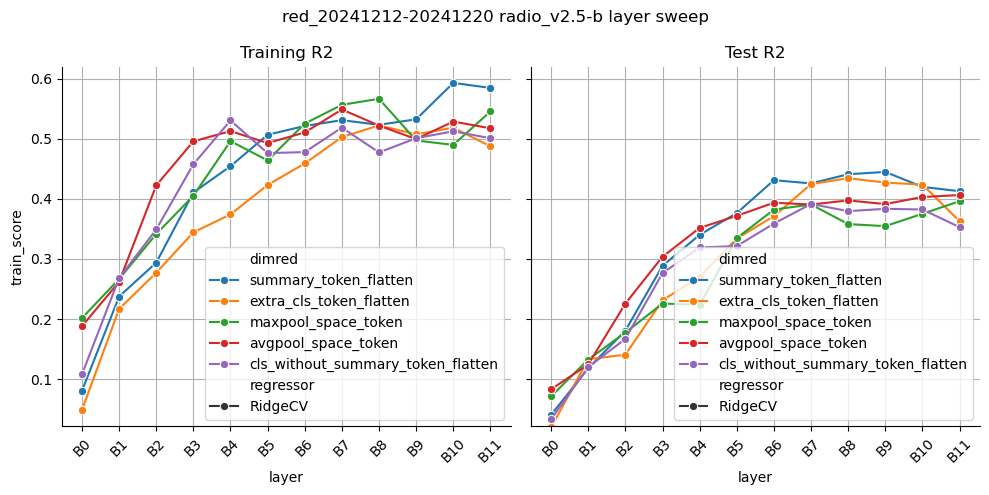

In [123]:
layer_shorten_func = lambda x: x.replace(".model.blocks.Block", "B")
result_df_formatted = format_result_df(result_df_lyrswp, dimred_list=list(Xtransforms_dict))
figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func, sharey=True, grid=True)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
figh.show()

In [124]:
layer_shorten_func = lambda x: x.replace(".model.blocks.Block", "B")
result_df_formatted = format_result_df(result_df_lyrswp, dimred_list=list(Xtransforms_dict))
figh = plot_result_df_per_layer(result_df_formatted, shorten_func=layer_shorten_func, sharey=True, grid=True)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh,)
    result_df_masked_formatted = format_result_df(result_df_masked, dimred_list=list(Xtransforms_dict))
    figh = plot_result_df_per_layer(result_df_masked_formatted, shorten_func=layer_shorten_func, sharey=True, grid=True)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
plt.close("all")

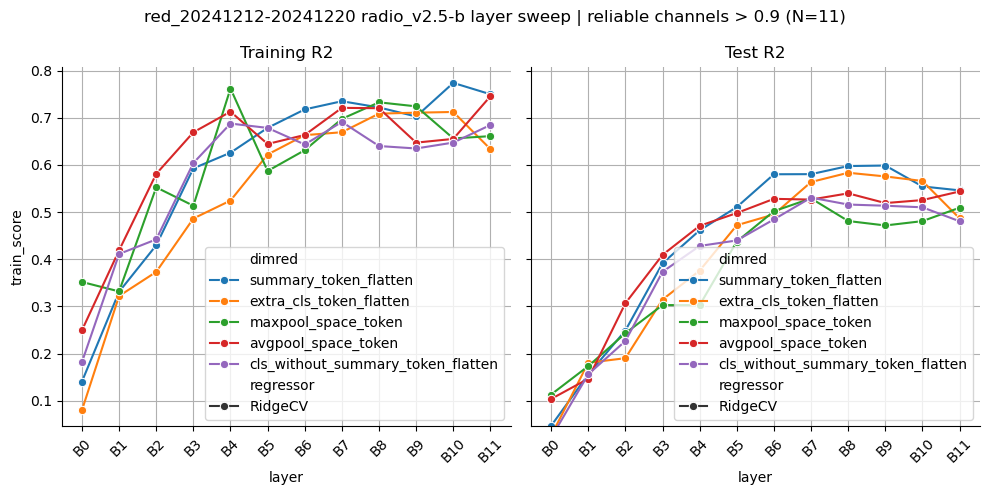

In [128]:
figh

### Export the models

In [129]:
from neural_regress.sklearn_torchify_lib import LinearLayer_from_sklearn
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"

In [133]:

modelname = "radio_v2.5-b"
keys2export = [ 
               ('.model.blocks.Block9_summary_token_flatten', 'RidgeCV')
            ]
# for modelname in ["dinov2_vitb14_reg"]:
Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth")
readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")
meta_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
fit_models_lyrswp_RidgeCV = th.load(readout_path)
Xtfmer_lyrswp_RidgeCV = th.load(Xtransform_path)
pred_data = pkl.load(open(meta_path, "rb"))
for key in keys2export:
    export_readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
    export_Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pth")
    export_meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

    regressor = fit_models_lyrswp_RidgeCV[key]
    Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
    pred_rsp = pred_data["pred_dict"][key]
    D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
    D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]
    readout = LinearLayer_from_sklearn(regressor)
    th.save(readout, export_readout_path)
    th.save(Xtfmer, export_Xtransform_path)
    Xtfmer_script = torch.jit.script(Xtfmer)
    Xtfmer_script.save(export_Xtransform_path.replace(".pth", "_JITscript.pt"))
    th.save({
        "reliability": reliability,
        "ncsnr": ncsnr,
        "D2_per_unit_test": D2_per_unit_test,
        "D2_per_unit_train": D2_per_unit_train
    }, export_meta_path)
    print(f"Saved {export_readout_path}")
    print(f"Saved {export_Xtransform_path}")
    print(f"JIT script saved to {export_Xtransform_path.replace('.pth', '_JITscript.pt')}")
    print(f"Saved {export_meta_path}")

Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_radio_v2.5-b_readout_.model.blocks.Block9_summary_token_flatten_RidgeCV.pth
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_radio_v2.5-b_Xtfmer_.model.blocks.Block9_summary_token_flatten_RidgeCV.pth
JIT script saved to /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_radio_v2.5-b_Xtfmer_.model.blocks.Block9_summary_token_flatten_RidgeCV_JITscript.pt
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_radio_v2.5-b_meta_.model.blocks.Block9_summary_token_flatten_RidgeCV.pkl


In [96]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/red_20241212-20241220/model_outputs/*.pt

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/red_20241212-20241220/model_outputs/red_20241212-20241220_dinov2_vitb14_reg_sweep_regressors_layers_Xtfmer_RidgeCV.pt
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/red_20241212-20241220/model_outputs/red_20241212-20241220_radio_v2.5-b_sweep_regressors_layers_Xtfmer_RidgeCV.pt


### Testing model

In [14]:
import torch
from os.path import join
import torchvision.transforms as T

device = "cuda"
subject_id = "red_20241212-20241220"
modelname = "radio_v2.5-b"
key = ('.model.blocks.Block9_summary_token_flatten', 'RidgeCV')
layer_name = '.model.blocks.Block9'
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"
readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pth")
meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

# model, transforms_pipeline = load_model_transform(modelname, device=device)
ckpt_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_backbones'
radio_model = torch.hub.load('NVlabs/RADIO', 'radio_model', version=model_version, progress=True, skip_validation=True)
radio_model = radio_model.eval().to(device)
radio_model.requires_grad_(False)
transforms_pipeline = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name, ingraph=True, store_device=device)

# state_dict = th.load(readout_path)
# readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
# readout.load_state_dict(state_dict)
# the latest loading method
readout = th.load(readout_path).to(device)
Xtransform = th.load(Xtransform_path).to(device)
meta_info = th.load(meta_path)

def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
    
check_gradient(population_prediction)

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main


torch.Size([1, 64])


### Check activation matching

In [20]:
import os
import pandas as pd
import re

def extract_stimulus_parameters(stim_dir):
    """
    Extract parameters from stimulus filenames in the given directory.
    
    Parameters:
    -----------
    stim_dir : str
        Path to the directory containing stimulus PNG files
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing extracted parameters from filenames
    """
    # Get all PNG files in the directory
    stim_files = [f for f in os.listdir(stim_dir) if f.endswith('.png')]
    
    # Regular expression pattern to extract parameters from filenames
    pattern = r'(.*)_unit_(\d+)_img_(\d+)_level_(\d+\.\d+)_score_(\d+\.\d+)\.png'
    
    # Create a list to store extracted data
    data = []
    
    # Extract parameters from each filename
    for filename in stim_files:
        match = re.match(pattern, filename)
        if match:
            model_type, unit_id, img_id, level, score = match.groups()
            data.append({
                'filename': filename,
                'model_type': model_type,
                'unit_id': int(unit_id),
                'img_id': int(img_id),
                'target_level': float(level),
                'score': float(score)
            })
    
    # Create a DataFrame from the extracted data
    stim_params_df = pd.DataFrame(data)
    
    return stim_params_df

fa_stimdir = "/n/netscratch/kempner_fellows/Lab/tfel/prj_control/22-04-2025_accentuation"
# Extract parameters from stimulus files
stim_params_df = extract_stimulus_parameters(fa_stimdir)

# Display the DataFrame
print(f"Found {len(stim_params_df)} stimulus files")
stim_params_df.head()

Found 171 stimulus files


,filename,model_type,unit_id,img_id,target_level,score
0,radiov2.5_RidgeCV_unit_1_img_0_level_0.3299293...,radiov2.5_RidgeCV,1,0,0.329929,0.337225
1,radiov2.5_RidgeCV_unit_1_img_0_level_0.7381472...,radiov2.5_RidgeCV,1,0,0.738147,0.728864
2,radiov2.5_RidgeCV_unit_1_img_0_level_1.1463652...,radiov2.5_RidgeCV,1,0,1.146365,1.137822
3,radiov2.5_RidgeCV_unit_1_img_0_level_1.5545832...,radiov2.5_RidgeCV,1,0,1.554583,1.547994
4,radiov2.5_RidgeCV_unit_1_img_0_level_1.9628012...,radiov2.5_RidgeCV,1,0,1.962801,1.957096


In [22]:
from circuit_toolkit.dataset_utils import ImagePathDataset

image_fps = stim_params_df['filename'].tolist()
# join the image_fps with the fa_stimdir
image_fps = [os.path.join(fa_stimdir, img_path) for img_path in image_fps]
dataset = ImagePathDataset(image_fps, scores=None, transform=transforms_pipeline)

The (227, 227) setting is overwritten by the size in custom transform


In [40]:
from torch.utils.data import DataLoader
from tqdm import tqdm
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
model_pred = []
for batch in tqdm(dataloader):
    images, _ = batch
    with th.no_grad():
        preds = population_prediction(images.cuda())
    model_pred.append(preds.cpu())

model_pred = torch.cat(model_pred, dim=0)
model_pred.shape

100%|██████████| 171/171 [01:00<00:00,  2.82it/s]


torch.Size([171, 64])

In [42]:
target_scores_BW = []
for row_idx, row in stim_params_df.iterrows():
    unit_id = row['unit_id']
    # score = row['score']
    model_pred_unit = model_pred[row_idx, unit_id]
    target_scores_BW.append(model_pred_unit)

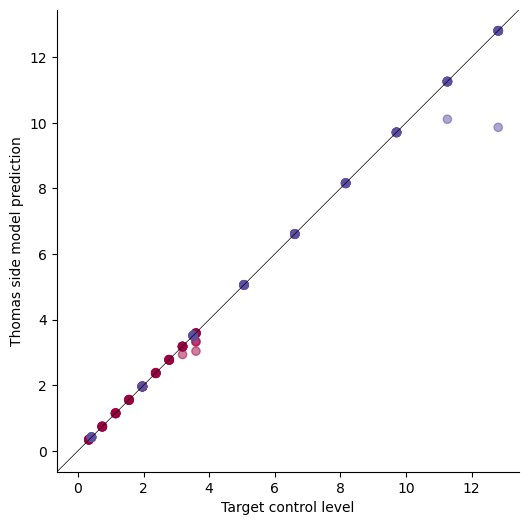

In [50]:
# plot the model prediction vs the score
plt.figure(figsize=(6, 6))
plt.scatter(stim_params_df['target_level'], stim_params_df['score'], c=stim_params_df['unit_id'], alpha=0.5, cmap="Spectral")
plt.axline(xy1=(0, 0), xy2=(1, 1), color='black', linewidth=0.5)
plt.xlabel('Target control level')
plt.ylabel('Thomas side model prediction')
plt.axis('image')
plt.show()

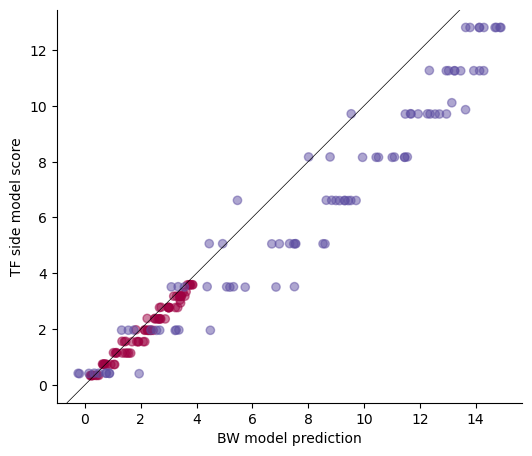

In [51]:
plt.figure(figsize=(6, 6))
# plot the model prediction vs the score
plt.scatter(target_scores_BW, stim_params_df['score'], 
            c=stim_params_df['unit_id'], alpha=0.5, cmap="Spectral") #
plt.axline(xy1=(0, 0), xy2=(1, 1), color='black', linewidth=0.5)
plt.xlabel('BW model prediction')
plt.ylabel('TF side model score')
plt.axis('image')
plt.show()

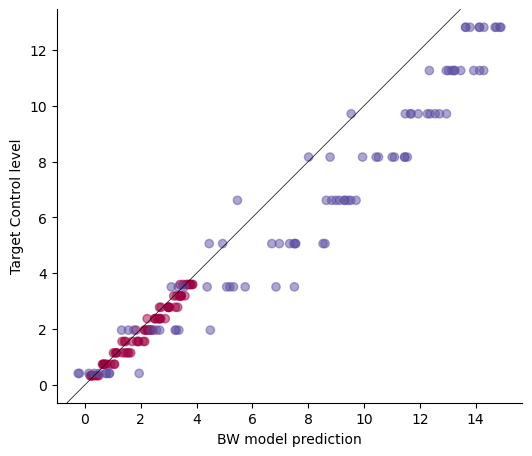

In [52]:
plt.figure(figsize=(6, 6))
# plot the model prediction vs the score
plt.scatter(target_scores_BW, stim_params_df['target_level'], 
            c=stim_params_df['unit_id'], alpha=0.5, cmap="Spectral") #
plt.axline(xy1=(0, 0), xy2=(1, 1), color='black', linewidth=0.5)
plt.xlabel('BW model prediction')
plt.ylabel('Target Control level')
plt.axis('image')
plt.show()

### Pipeline

In [ ]:
# subject_id = 'paul_240713-240710'
# for subject_id in ['paul_240713-240710', 
#                    'paul_20240713-20240710', 
#                    'red_20240713-20240710',
#                    'baby1_20240329-20240325', 
#                    'baby1_240329-240325', 
#                    'baby5_240819-240822', ]: 
#%%
batch_size = 64
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
for modelname in ["clipag_vitb32", ]: # 
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset with transforms
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
    # Prepare fetcher
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    module_names = [name for name in fetcher.module_names.values() if "ResidualAttentionBlock" in name]
    # Add hooks to all layers / blocks in resnet50
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )

    # Record features
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()
    th.cuda.empty_cache()
    #%%
    resp_mat_sel = resp_mat
    print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
    # result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer(feat_dict_lyrswp, 
    #             resp_mat_sel, layer_names=module_names, # 'layer2', 'layer3', 
    #             regressor_list=["Ridge",], dimred_list=["pca1000", "srp", "srp1000", "srp2000"], verbose=True) # "sp_cent", "sp_avg", 
    result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, 
                resp_mat_sel, layer_names=module_names, alpha_per_target=True, 
                alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                dimred_list=["pca1000", "srp", "srp1000",], verbose=True, use_pca_dual=True) # "sp_cent", "sp_avg", regressor_list=["Ridge",], 

    pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)
    pkl.dump(pred_D2_dict, 
            open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
    result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
    # th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
    # pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

    # %%
    
    figh = plot_result_df_per_layer(result_df_lyrswp, )
    figh.suptitle(f"{subject_id} {modelname} layer sweep")
    figh.tight_layout()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
    # %%
    # Mask out unreliable channels and plot again
    for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
        channel_count = (reliability > thresh).sum()
        result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                    pred_D2_dict['D2_per_unit_test_dict'], 
                                                    mask=reliability > thresh)
        figh = plot_result_df_per_layer(result_df_masked, )
        figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
        figh.tight_layout()
        figh.show()
        saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
    plt.close("all")
    

### Supplementary: Large high resolution image encoding of RADIOv2.5

In [105]:
batch_size = 96
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
# modelname = "radio_v2.5-b"  # for RADIOv2.5-B model (ViT-B/16)
model_version = "radio_v2.5-b"
modelname = "radio_v2.5-b_res768"
resolution = (768, 768)
#model_version="e-radio_v2" # for E-RADIO
model = torch.hub.load('NVlabs/RADIO', 'radio_model', version=model_version, progress=True, skip_validation=True)
model = model.eval().to(device)
model.requires_grad_(False)
transforms_pipeline = T.Compose([
    T.ToTensor(),
    T.Resize(resolution),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Prepare dataset with transforms
dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
# Prepare fetcher
fetcher = featureFetcher(model, input_size=(3, 768, 768), print_module=False)
module_names = [name for name in fetcher.module_names.values() if ".model.blocks.Block" in name]
# Add hooks to all layers / blocks in resnet50
for name in module_names: 
    fetcher.record(name, store_device='cpu', ingraph=False, )

# # Record features
feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()
th.cuda.empty_cache()

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main


The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/11 [00:00<?, ?it/s]

.model.blocks.Block0 torch.Size([1028, 2312, 768])
.model.blocks.Block1 torch.Size([1028, 2312, 768])
.model.blocks.Block2 torch.Size([1028, 2312, 768])
.model.blocks.Block3 torch.Size([1028, 2312, 768])
.model.blocks.Block4 torch.Size([1028, 2312, 768])
.model.blocks.Block5 torch.Size([1028, 2312, 768])
.model.blocks.Block6 torch.Size([1028, 2312, 768])
.model.blocks.Block7 torch.Size([1028, 2312, 768])
.model.blocks.Block8 torch.Size([1028, 2312, 768])
.model.blocks.Block9 torch.Size([1028, 2312, 768])
.model.blocks.Block10 torch.Size([1028, 2312, 768])
.model.blocks.Block11 torch.Size([1028, 2312, 768])
FeatureFetcher hooks all freed


In [106]:
summary_idxs = model.summary_idxs.cpu()
max_summary_idx = summary_idxs.max() + 1
num_skip = model.model.patch_generator.num_skip
num_cls_tokens = model.model.patch_generator.num_cls_tokens

Xtransforms_dict = {
    "summary_token_flatten": SummaryFlatten(summary_idxs),
    "extra_cls_token_flatten": ExtraClsFlatten(max_summary_idx, num_cls_tokens),
    "maxpool_space_token": MaxPoolSpaceToken(num_skip),
    "avgpool_space_token": AvgPoolSpaceToken(num_skip),
    "cls_without_summary_token_flatten": ClsWithoutSummaryFlatten(max_summary_idx, num_skip),
}
Xdict_lyrswp = {}
Xtfmer_lyrswp = {}
for layer in module_names:
    for dimred_str, transform_func in Xtransforms_dict.items():
        t0 = time.time()
        Xdict_lyrswp[f"{layer}_{dimred_str}"] = transform_func(feat_dict_lyrswp[layer])
        Xtfmer_lyrswp[f"{layer}_{dimred_str}"] = transform_func
        print(f"Time taken to transform {layer} x {dimred_str}: {time.time() - t0:.3f}s")
resp_mat_sel = resp_mat
# Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "avgtoken", "clstoken"],  #  "srp"
#                                                         pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV"] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth"))
# pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))


Time taken to transform .model.blocks.Block0 x summary_token_flatten: 0.004s
Time taken to transform .model.blocks.Block0 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block0 x maxpool_space_token: 7.739s
Time taken to transform .model.blocks.Block0 x avgpool_space_token: 0.626s
Time taken to transform .model.blocks.Block0 x cls_without_summary_token_flatten: 0.000s
Time taken to transform .model.blocks.Block1 x summary_token_flatten: 0.004s
Time taken to transform .model.blocks.Block1 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block1 x maxpool_space_token: 7.430s
Time taken to transform .model.blocks.Block1 x avgpool_space_token: 0.628s
Time taken to transform .model.blocks.Block1 x cls_without_summary_token_flatten: 0.000s
Time taken to transform .model.blocks.Block2 x summary_token_flatten: 0.004s
Time taken to transform .model.blocks.Block2 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block2 x maxpool

In [108]:
result_df_formatted.test_score.max()

0.44821649285839826

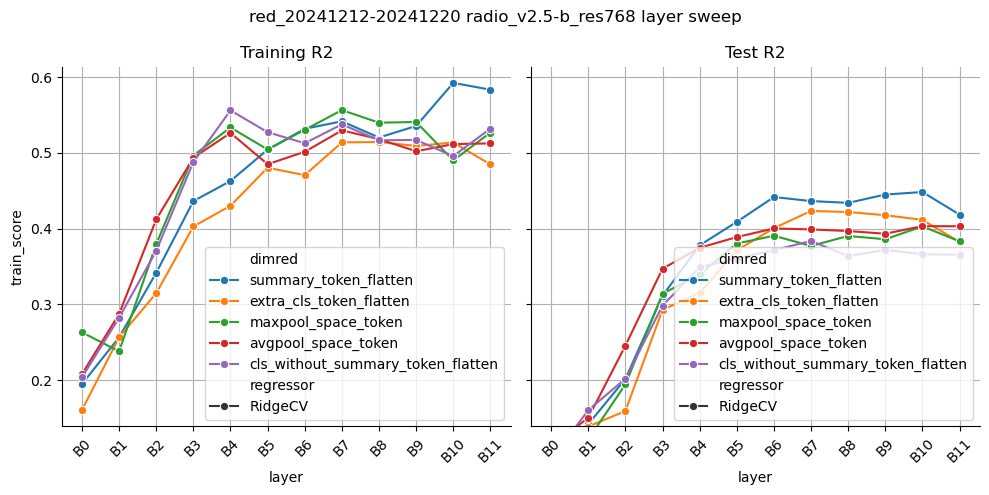

In [107]:
layer_shorten_func = lambda x: x.replace(".model.blocks.Block", "B")
result_df_formatted = format_result_df(result_df_lyrswp, dimred_list=list(Xtransforms_dict))
figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func, sharey=True, grid=True)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
figh.show()

In [109]:
layer_shorten_func = lambda x: x.replace(".model.blocks.Block", "B")
result_df_formatted = format_result_df(result_df_lyrswp, dimred_list=list(Xtransforms_dict))
figh = plot_result_df_per_layer(result_df_formatted, shorten_func=layer_shorten_func, sharey=True, grid=True)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh,)
    result_df_masked_formatted = format_result_df(result_df_masked, dimred_list=list(Xtransforms_dict))
    figh = plot_result_df_per_layer(result_df_masked_formatted, shorten_func=layer_shorten_func, sharey=True, grid=True)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
plt.close("all")

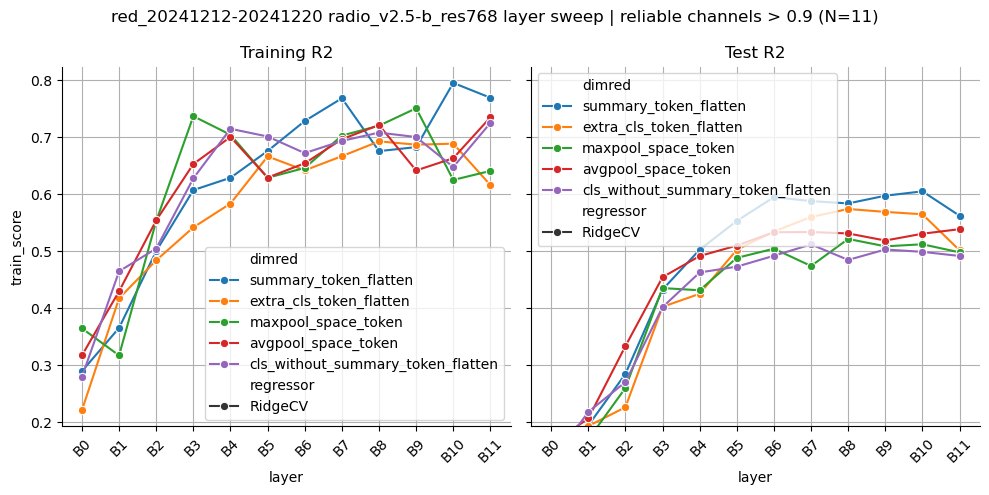

In [110]:
figh